# Apply spaTrack on spatial data of Intrahepatic cholangiocarcinoma cancer

Rebuilding lineages of tumorigenesis can improve us understand the deterioration and developmental process of primary tumors and describe the behaviors of malignant cells.Considering the heterozygosity and complex of malignant cells, it is possible that tumors originate from multiple started regions. Here, we performed spaTrack to rebuild the diverse lineages of ICC tumorigenesis by spatial transcriptomics data of ICC tumor section. This notebook uses the intrahepatic cholangiocarcinoma cancer (ICC) ST data to show how spaTrack infer trajectories when data has multiple origins. Spatial transcriptomics data of ICC can be download from our [example data](http://116.6.21.110:8090/share/c5d9e7f3-7d66-4154-87e1-a740f4bb4dbc).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import stereo as st

## Loading data and preprocessing

In this data, the cell type information is stored in `data.cells['cluster']` or `data.adata.obs['cluster']`.

In [2]:
data = st.io.read_h5ad('../../data/02.ICC.primary.ST.data/02.ICC.primary.ST.h5ad')

In [3]:
cluster_res_key = 'cluster'

Running `data.tl.raw_checkpoint()` to save the raw expression matrix for use when needed.

In [4]:
data.tl.cal_qc()
data.tl.filter_genes(min_cells=10)
data.tl.raw_checkpoint()
data.tl.normalize_total(add_layer=True)
data.tl.log1p(add_layer=True)

[2024-11-05 11:51:47][Stereo][14264][MainThread][140704227698496][st_pipeline][41][INFO]: start to run cal_qc...
[2024-11-05 11:51:48][Stereo][14264][MainThread][140704227698496][st_pipeline][44][INFO]: cal_qc end, consume time 0.1906s.
[2024-11-05 11:51:48][Stereo][14264][MainThread][140704227698496][st_pipeline][41][INFO]: start to run filter_genes...
[2024-11-05 11:51:48][Stereo][14264][MainThread][140704227698496][st_pipeline][44][INFO]: filter_genes end, consume time 0.2890s.
[2024-11-05 11:51:48][Stereo][14264][MainThread][140704227698496][st_pipeline][41][INFO]: start to run normalize_total...
[2024-11-05 11:51:48][Stereo][14264][MainThread][140704227698496][st_pipeline][44][INFO]: normalize_total end, consume time 0.1024s.
[2024-11-05 11:51:48][Stereo][14264][MainThread][140704227698496][st_pipeline][41][INFO]: start to run log1p...
[2024-11-05 11:51:48][Stereo][14264][MainThread][140704227698496][st_pipeline][44][INFO]: log1p end, consume time 0.2133s.


Visualization of the cell type information.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

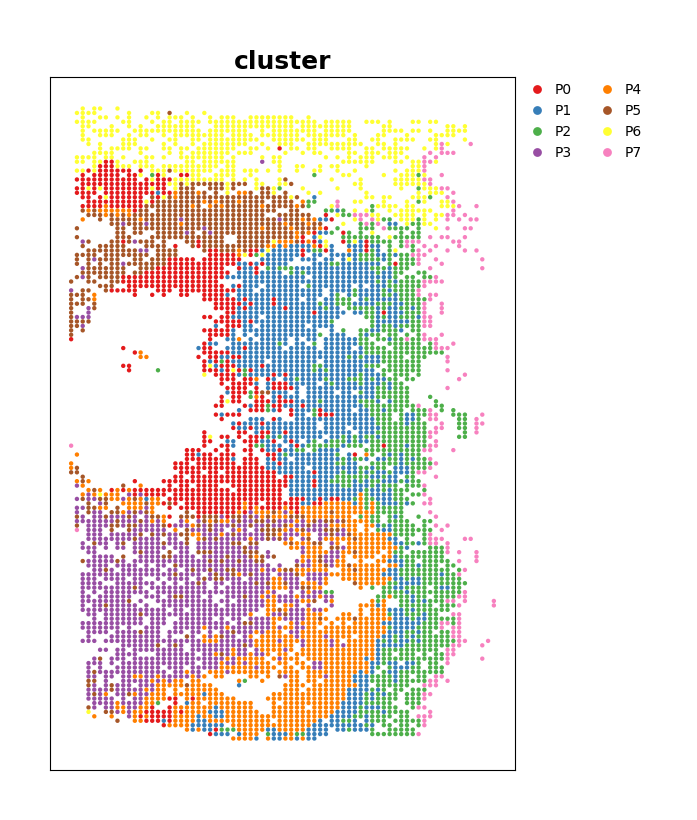

In [5]:
data.plt.cluster_scatter(res_key=cluster_res_key, invert_y=False, marker='o', dot_size=10, show_plotting_scale=False, width=600, height=900)

## Get An object of spaTrack

Set the cell type information to be used through parameter `cluster_res_key`.

In [6]:
spt = data.tl.spa_track(cluster_res_key=cluster_res_key)

2024-11-05 11:51:50.300226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[2024-11-05 11:51:52][Stereo][14264][MainThread][140704227698496][st_pipeline][77][INFO]: register algorithm spa_track to <stereo.core.st_pipeline.AnnBasedStPipeline object at 0x7ff7c8fc9a90>


## Choose start cells

In order to identify potential start regions, multiple factors were considered. We recommend that users manually slecte starting cluster base on prior knowledge within this field. In cases where prior knowledge and biological evidence were not available to support the selection of start cells, we suggested using entropy value. 

In our analysis of the ICC tumor ST data, we found that the P0 cluster demonstrated a relatively high entropy value, indicating more likely to be starting cluster compared to the other clusters. As a result, P0 was selected as the starting cluster for further investigation.

In [7]:
spt.assess_start_cluster()

[2024-11-05 11:51:53][Stereo][14264][MainThread][140704227698496][start_cluster][34][INFO]: Cluster order sorted by entropy value: ['P0', 'P1', 'P5', 'P2', 'P4', 'P3', 'P6', 'P7']


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

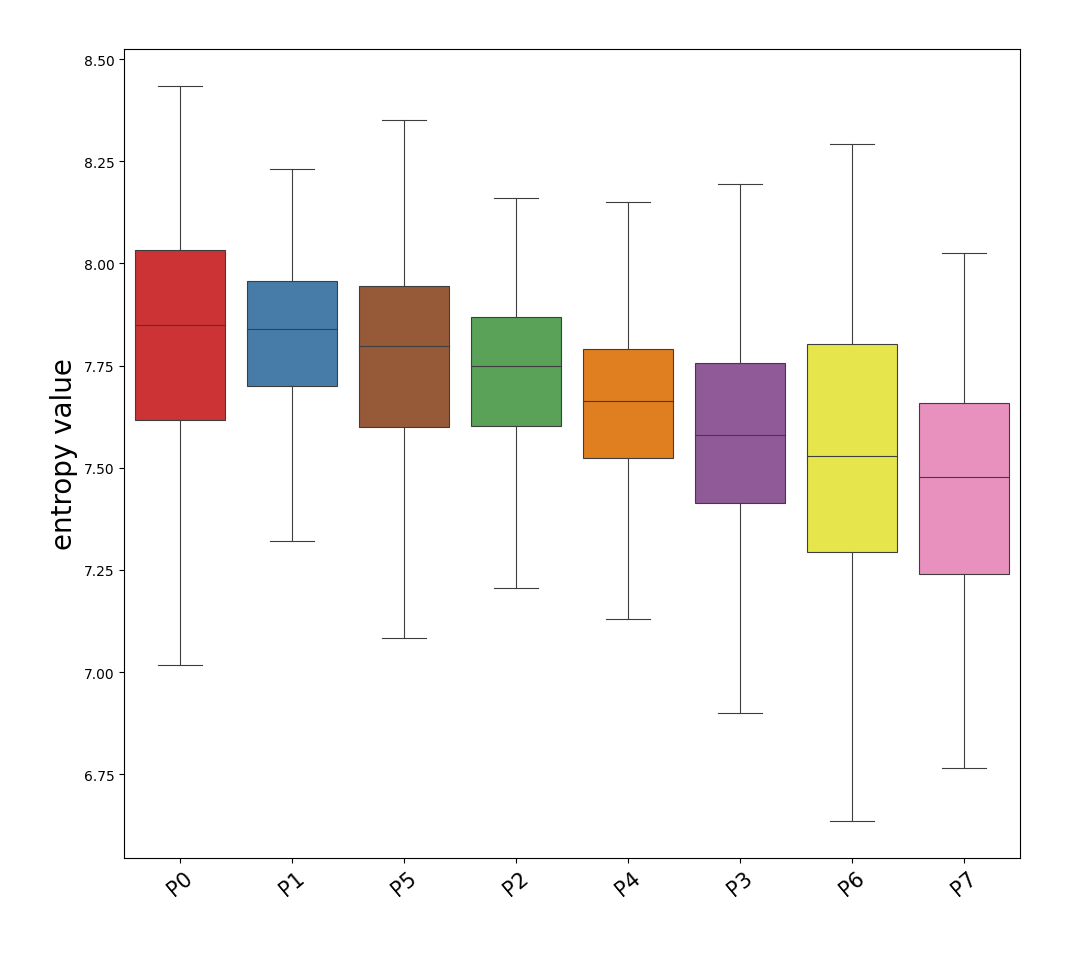

In [8]:
spt.plot.assess_start_cluster_plot()

Since the P0 cluster was distributed across four distinct regions, we used the k-means method with a cluster number of 4 to identify the aggregation points of the P0 cluster. Neighbor cells were then taken as start cells for the trajectory inference.

In [9]:
start_cells = spt.set_start_cells(select_way='cell_type', split=True, cell_type='P0',n_neigh=100, n_clusters=4)

kmeans cluster centers:
[ 2401.94552529 14197.27626459]
[ 2812.43093923 10337.84530387]
[  866.37931034 16618.10344828]
[1654.16666667 4750.        ]


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

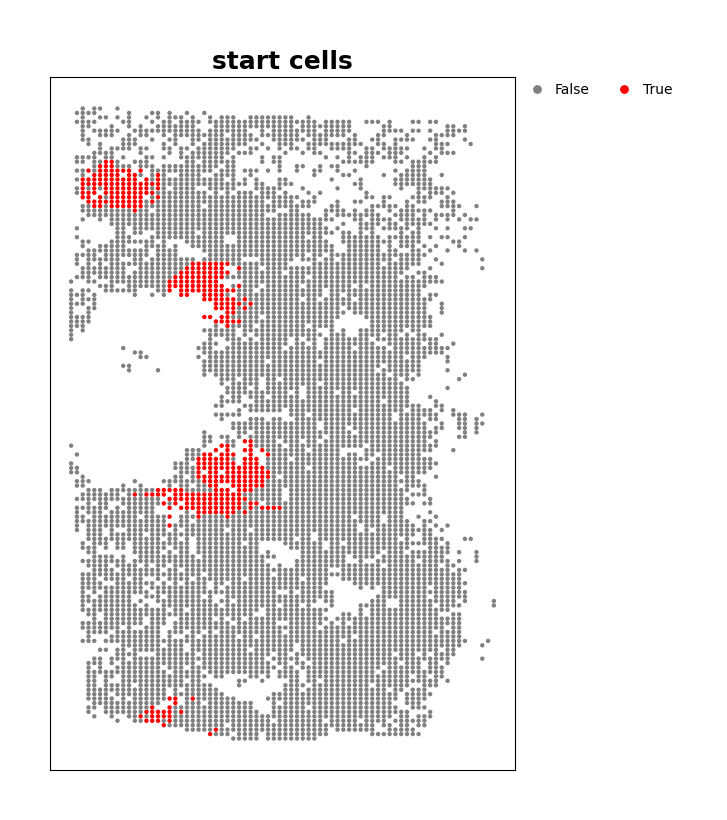

In [10]:
data.plt.cluster_scatter(
    res_key='start_cells',
    marker='o',
    dot_size=10,
    title='start cells',
    invert_y=False, 
    show_plotting_scale=False,
    palette=['gray', 'red'],
    width=600, height=900
)

## Calculate cell transition probability

Parameter estimation of alpah1 for gene expression and alpah2 for spatial distance.

In [ ]:
alpha1, alpha2 = spt.auto_estimate_param(n_hvg=2000)
alpha1, alpha2

[2024-11-05 11:51:54][Stereo][14264][MainThread][140704227698496][st_pipeline][41][INFO]: start to run highly_variable_genes...
[2024-11-05 11:51:55][Stereo][14264][MainThread][140704227698496][st_pipeline][44][INFO]: highly_variable_genes end, consume time 0.4153s.
[2024-11-05 11:51:55][Stereo][14264][MainThread][140704227698496][velocity][230][INFO]: Parameter estimation of alpah1 for gene expression is: 0.5
[2024-11-05 11:51:55][Stereo][14264][MainThread][140704227698496][velocity][231][INFO]: Parameter estimation of alpah2 for spatial distance is: 0.782


(0.5, 0.782)

Calculate cell transition probability based on gene expression matrix and cell spatial coordinate.

In [12]:
spt.get_ot_matrix(data_type="spatial", alpha1=alpha1, alpha2=alpha2)

[2024-11-05 11:51:55][Stereo][14264][MainThread][140704227698496][velocity][88][INFO]: Can not find PCA result, to calculate automatically using highly variable genes.
[2024-11-05 11:51:55][Stereo][14264][MainThread][140704227698496][velocity][89][INFO]: n_pcs: 50
[2024-11-05 11:51:55][Stereo][14264][MainThread][140704227698496][st_pipeline][41][INFO]: start to run pca...
[2024-11-05 11:51:59][Stereo][14264][MainThread][140704227698496][st_pipeline][44][INFO]: pca end, consume time 3.7386s.
[2024-11-05 11:51:59][Stereo][14264][MainThread][140704227698496][velocity][124][INFO]: alpha1(gene expression): 0.5   alpha2(spatial information): 0.782


array([[0.00000000e+00, 9.29136140e-09, 9.79982813e-09, ...,
        2.38553588e-09, 2.12212983e-08, 3.84189677e-10],
       [9.29136110e-09, 0.00000000e+00, 6.16375165e-08, ...,
        5.64771372e-08, 2.26752487e-08, 2.64036400e-08],
       [9.79982782e-09, 6.16375165e-08, 0.00000000e+00, ...,
        4.86522670e-08, 3.69960520e-08, 2.56817694e-08],
       ...,
       [2.38553578e-09, 5.64771366e-08, 4.86522665e-08, ...,
        0.00000000e+00, 1.68871620e-08, 5.44206303e-08],
       [2.12212979e-08, 2.26752490e-08, 3.69960526e-08, ...,
        1.68871624e-08, 0.00000000e+00, 4.67600093e-09],
       [3.84189658e-10, 2.64036395e-08, 2.56817689e-08, ...,
        5.44206299e-08, 4.67600076e-09, 0.00000000e+00]])

## Caculate cell pseudotime

In [13]:
spt.get_ptime()

array([0.92126598, 0.42937325, 0.54895541, ..., 0.4303087 , 0.9808232 ,
       0.19363891])

Visualization of the inferred cell pseudotime.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

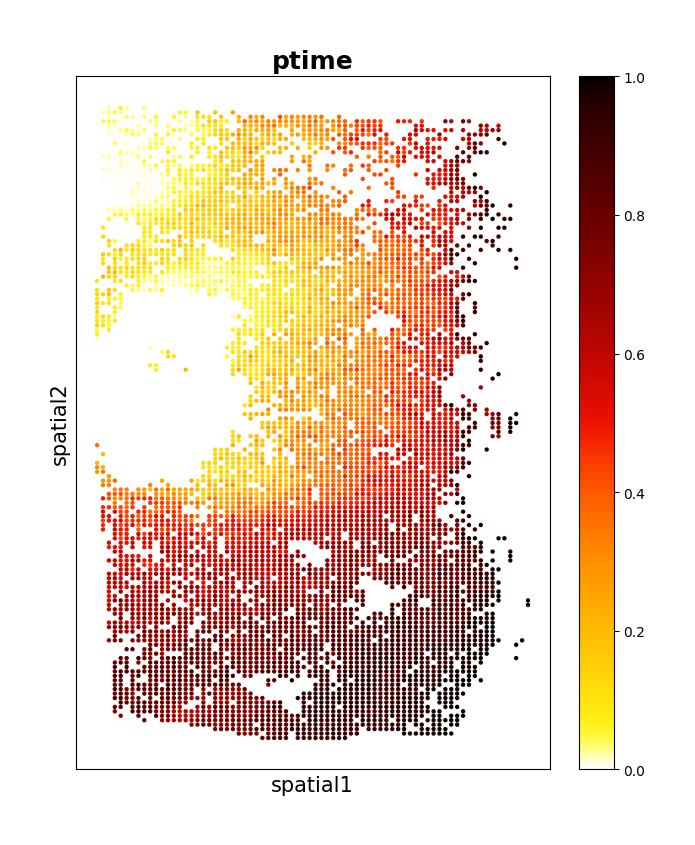

In [14]:
data.plt.spatial_scatter(
    cells_key='ptime', 
    marker='o', 
    dot_size=10, 
    palette='fire', 
    color_bar_reverse=True, 
    invert_y=False, 
    show_plotting_scale=False, 
    width=750, height=900
)

## Calculate vector field velocity.

Calculate vector field velocity by averaging the velocities of each cell and its neighbors.

In [15]:
spt.get_velocity(n_neigh_pos=100)

Visualization of the inferred cell trajectory.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

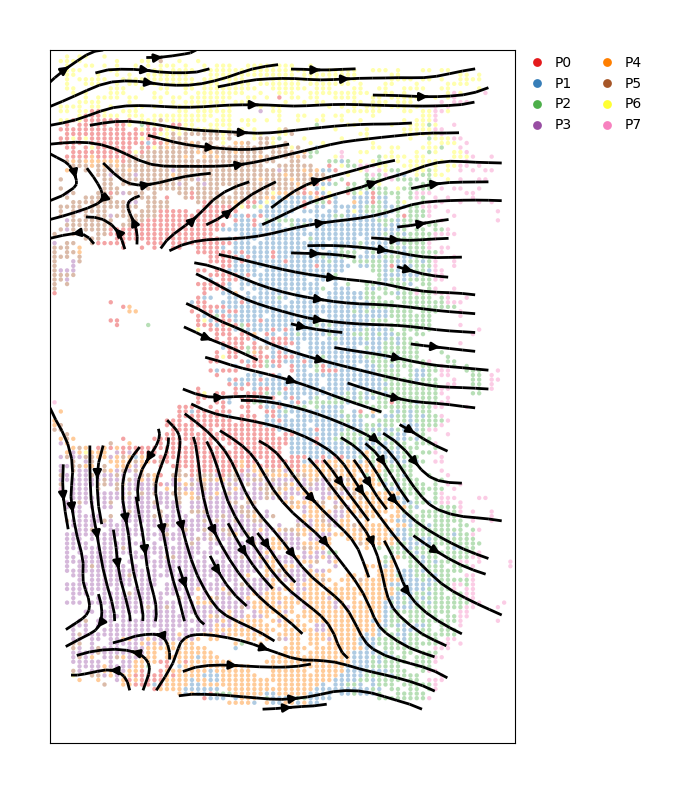

In [16]:
spt.plot.stremplot(
    dot_size=10, 
    invert_y=False, 
    width=600, 
    height=900, 
    stream_lines_density=1.2, 
    stream_lines_width=2, 
    stream_arrows_size=1.2
)

## Downstream analysis

In order to apply the LAP algorithm to spatial transcriptomics data, we need to reconstruct the grid-level vector field into cell-level data. This is done by interpolating the vector field values from the grid points to the cell locations, which enables us to calculate the velocity vectors for individual cells. The cell-level vector field is then used as input to the LAP algorithm to infer the optimal transition path between the chosen start and end points.

In [17]:
spt.create_vector_field()

### Least Action Path (LAP)

Select the start point and the end point across the direction of trajectory.

In [18]:
LAP_start_point=[1900,10000]
LAP_end_point=[4000,5800]

spt.set_lap_endpoints(
    LAP_start_point, LAP_end_point
)

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

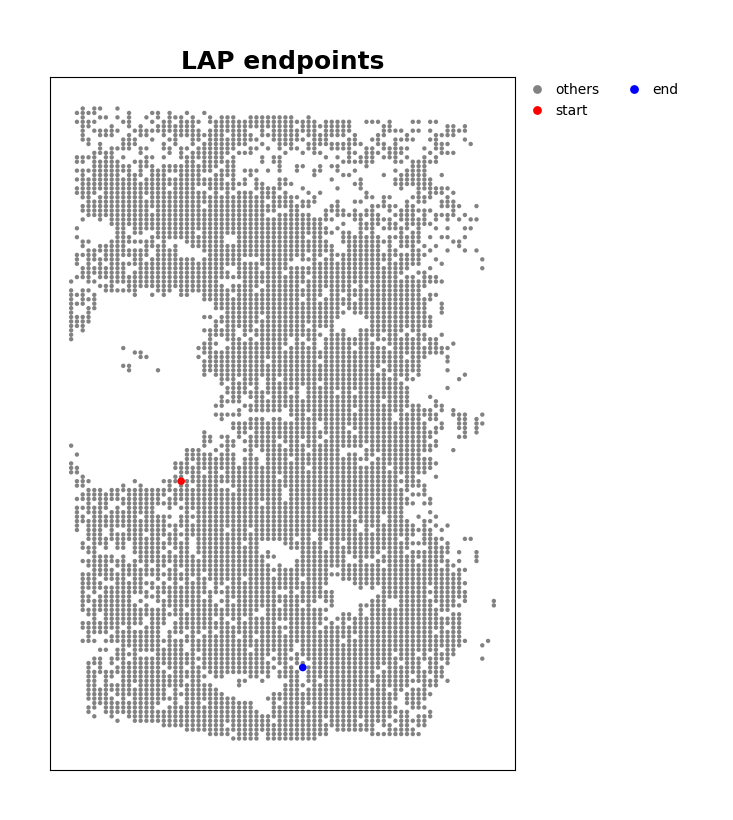

In [19]:
spt.plot.lap_endpoints(invert_y=False, dot_size=10, width=600, height=900)

Calculate the least action path between given start cell and end cell.

In [20]:
lap = spt.least_action(
    n_points = 20,
    EM_steps = 5
)

[2024-11-05 11:53:00][Stereo][14264][MainThread][140704227698496][st_pipeline][41][INFO]: start to run neighbors...
[2024-11-05 11:53:07][Stereo][14264][MainThread][140704227698496][st_pipeline][44][INFO]: neighbors end, consume time 6.9555s.


Visualization of LAP and color bar represents pseudotime.

In [21]:
spt.map_cell_to_LAP()

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

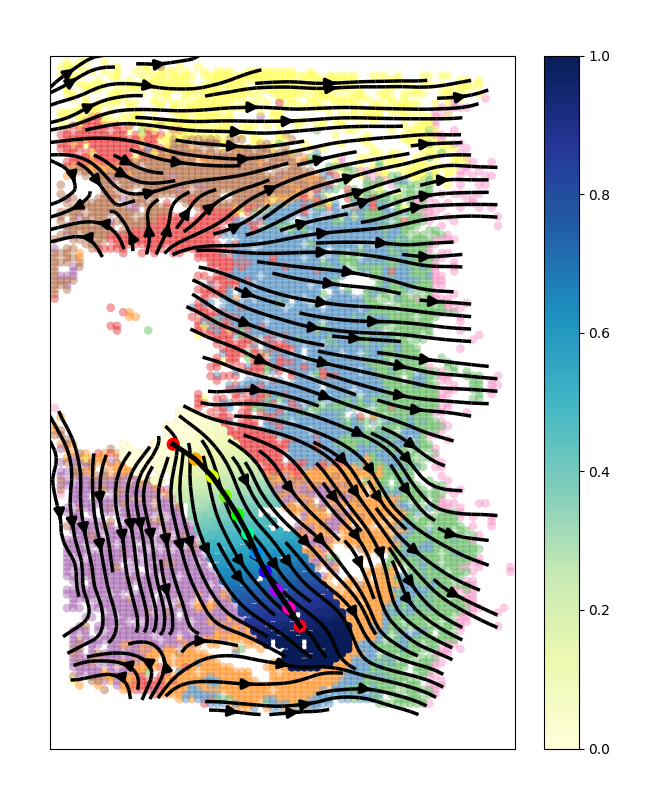

In [30]:
spt.plot.least_action_path(invert_y=False, dot_size=40, width=750, height=900)

### Pseudotime-dependent genes on LAPabs

Choose cell type of interest on LAP and filter genes with high variability which larger than minimum expression proportion.

In [23]:
data_filtered = spt.filter_genes(
    min_exp_prop_in_genes=0.1, n_hvg=5000, focused_cell_types=['P0','P3','P4']
)

[2024-11-05 11:53:12][Stereo][14264][MainThread][140704227698496][st_pipeline][41][INFO]: start to run highly_variable_genes...
[2024-11-05 11:53:12][Stereo][14264][MainThread][140704227698496][st_pipeline][44][INFO]: highly_variable_genes end, consume time 0.4282s.
[2024-11-05 11:53:12][Stereo][14264][MainThread][140704227698496][Pgene][121][INFO]: Cell number	660
[2024-11-05 11:53:12][Stereo][14264][MainThread][140704227698496][Pgene][122][INFO]: Gene number	1261


To investigate the relationship between gene expression changes and pseudotime values, we applied the generalized additive model (GAM). This allowed us to filter for pseudotime-dependent genes based on their model fit (R2) and false discovery rate (FDR). Only genes that showed significant associations with pseudotime values were selected as pseudotime-dependent genes.

In [24]:
df_res = spt.ptime_gene_GAM(data_filtered)

[2024-11-05 11:53:12][Stereo][14264][MainThread][140704227698496][Pgene][208][INFO]: Genes number fitted by GAM model:  1261


In [25]:
sort_exp_sig = spt.order_trajectory_genes(df_res, min_model_fit=0.15, max_fdr=0.05, cell_number=20)

[2024-11-05 11:53:44][Stereo][14264][MainThread][140704227698496][Pgene][319][INFO]: Finally selected 43 genes.


Use heatmap to display pseudotime-dependent genes.

Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

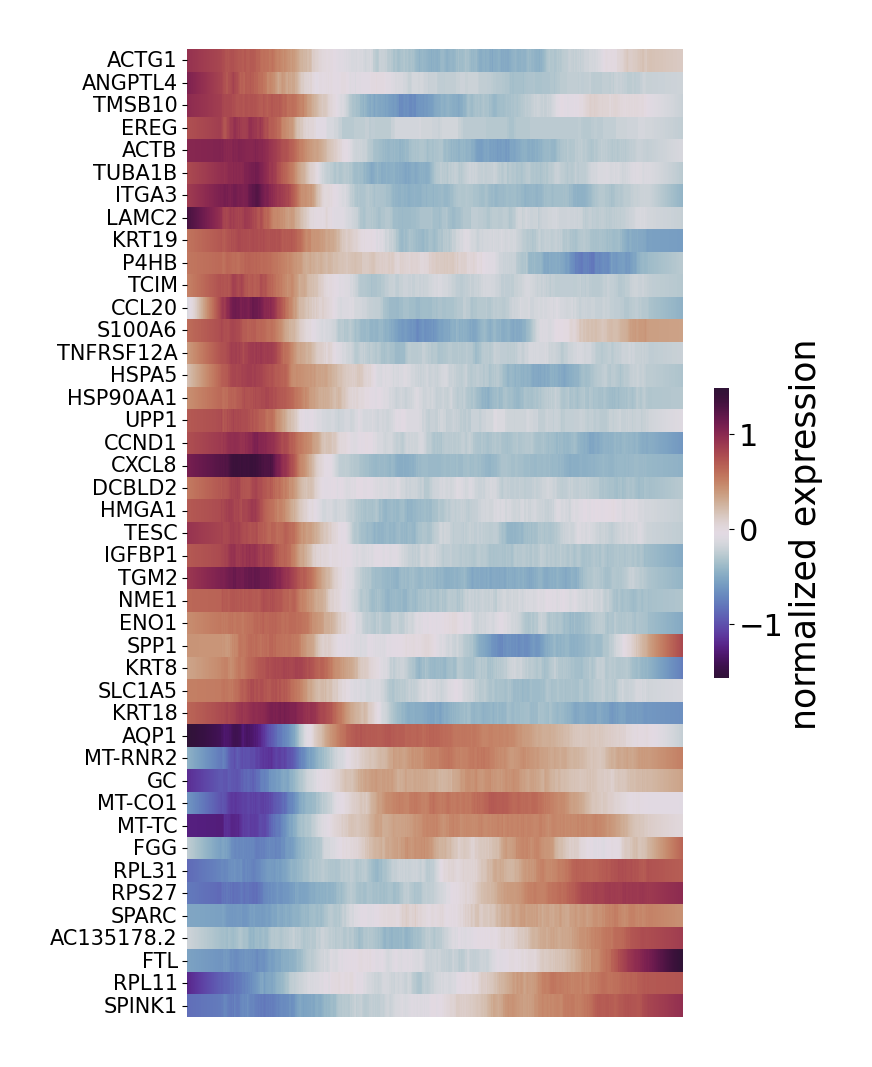

In [26]:
spt.plot.trajectory_gene_heatmap(sort_exp_sig, smooth_length=100, gene_label_size=15)

Show example of pseudotime-dependent genes.

[2024-11-05 11:53:45][Stereo][14264][MainThread][140704227698496][st_pipeline][41][INFO]: start to run highly_variable_genes...
[2024-11-05 11:53:45][Stereo][14264][MainThread][140704227698496][st_pipeline][44][INFO]: highly_variable_genes end, consume time 0.2671s.
[2024-11-05 11:53:45][Stereo][14264][MainThread][140704227698496][Pgene][121][INFO]: Cell number	660
[2024-11-05 11:53:45][Stereo][14264][MainThread][140704227698496][Pgene][122][INFO]: Gene number	1261


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

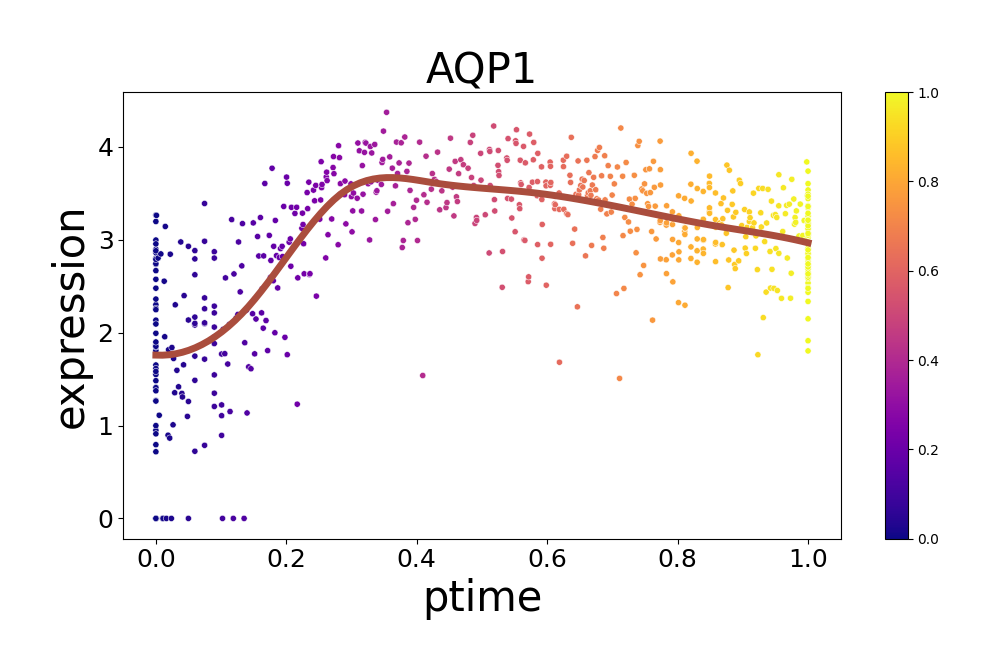

In [27]:
spt.plot.trajectory_gene(gene_name='AQP1',dot_size=20)

[2024-11-05 11:53:46][Stereo][14264][MainThread][140704227698496][st_pipeline][41][INFO]: start to run highly_variable_genes...
[2024-11-05 11:53:47][Stereo][14264][MainThread][140704227698496][st_pipeline][44][INFO]: highly_variable_genes end, consume time 0.4268s.
[2024-11-05 11:53:47][Stereo][14264][MainThread][140704227698496][Pgene][121][INFO]: Cell number	660
[2024-11-05 11:53:47][Stereo][14264][MainThread][140704227698496][Pgene][122][INFO]: Gene number	1261


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

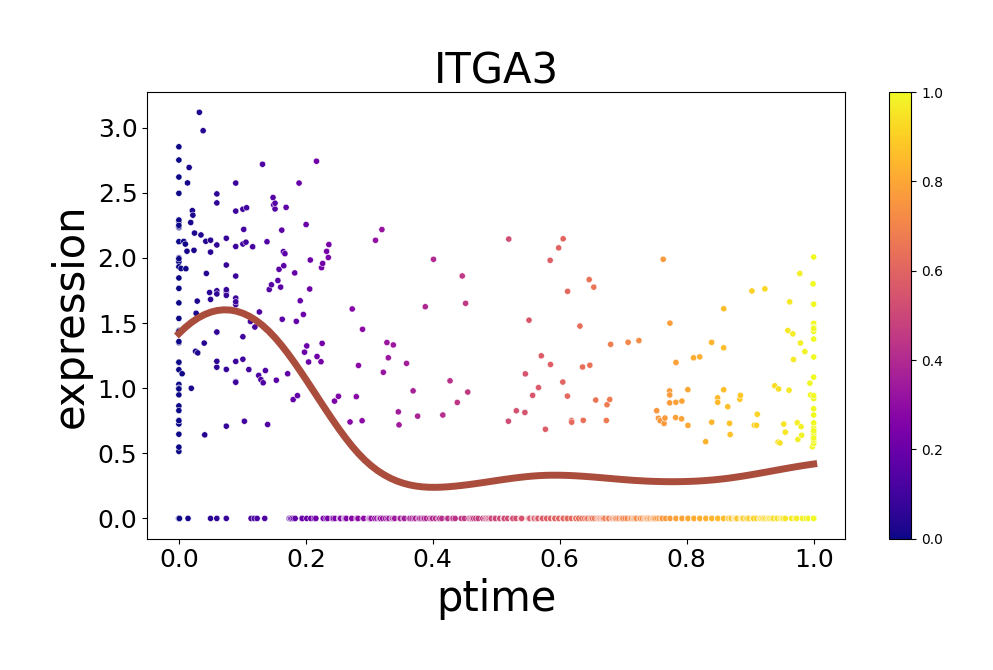

In [28]:
spt.plot.trajectory_gene(gene_name='ITGA3',dot_size=20)